## Generate input files

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

### Shape of the model

In [2]:
# Horizontal and vertical extent of the model in meters:
Lx, Lz = 40.0e3, 40.0e3

# Number of points in horizontal and vertical direction:
Nx, Nz = 11,11

In [3]:
x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)

X, Z = np.meshgrid(x, z)

### Define the thickness of the layers

They are in meters.

In [4]:
# Lower crust:
thickness_lower_crust = 20.0e3

# Upper crust:
thickness_upper_crust = 20.0e3


### Create the interfaces (bottom first)

In [5]:
interfaces = {
    "litho": np.ones(Nx) * (thickness_lower_crust),
}

Plot the interfaces:

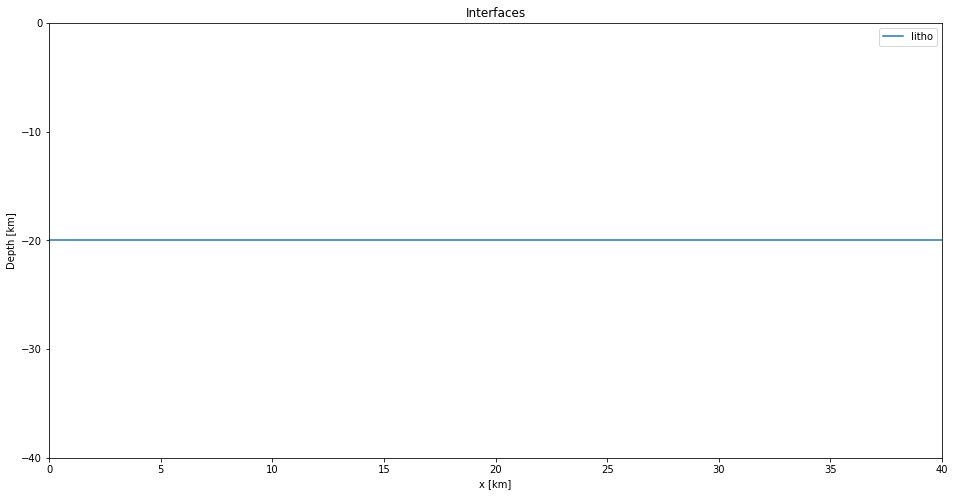

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

for label, layer in interfaces.items():
    ax.plot(x / 1e3, (-layer) / 1e3, label=f"{label}")

ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 10))
ax.set_xlim([0, Lx/1000])


ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

plt.title("Interfaces")
plt.legend()

plt.show()

#### Create the interface file

The interface file contain the layer properties and the interface's depth between these layers. 

Layer properties:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (v)

In [7]:
# Define the radiogenic heat for the upper and lower crust in W/kg:
Huc = 2.5e-6 / 2700.0
Hlc = 0.8e-6 / 2800.0

# Create and save the interface file:
with open("interfaces.txt", "w") as f:
    layer_properties = f"""
        C   1.0       1.0       
        rho 3300.0    3300.0    
        H   0.0       0.0   
        A   1.393e-14 1.393e-14
        n   3.0       3.0       
        Q   429.0e3   429.0e3
        V   15.0e-6   15.0e-6   
        k   1.0e-6    0.25e-6    
    """

    for line in layer_properties.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

    # layer interfaces
    data = -1 * np.array(tuple(interfaces.values())).T
    np.savetxt(f, data, fmt="%.1f")

In [8]:
kappa = 1.0e-6 # m^2/s
ccapacity = 1250 # J/(kg K)
tem_p = 1262  # °C
g = -10 # m/s^2
alpha = 3.28e-5 # 1/K

In [9]:
# Temperature when z < 130 km:
temp_z = 700 * z / Lz


Save initial temperature file:

In [10]:
temp_z = np.ones_like(X) * temp_z[:, None]

print(np.shape(temp_z))

# Save the initial temperature file
np.savetxt(
    "input_temperature_0.txt", 
    np.reshape(temp_z, (Nx * Nz)), 
    header="T1\nT2\nT3\nT4"
)

(11, 11)


Plot the temperature model:

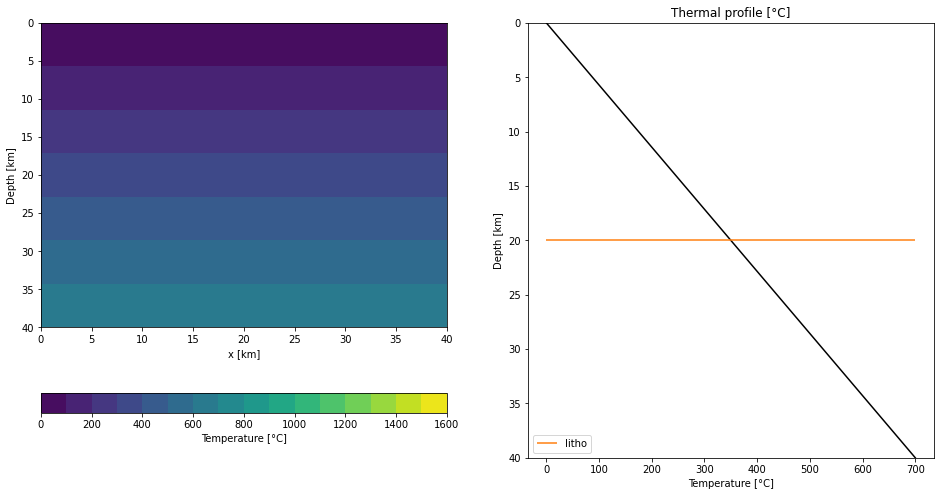

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Temperature field:
im1 = ax0.contourf(
    X / 1.0e3,
    (Z ) / 1.0e3,
    temp_z,
    levels=np.arange(0, 1610, 100)
    )

ax0.set_ylim((Lz) / 1.0e3, 0)
ax0.set_ylabel("Depth [km]")
ax0.set_xlabel("x [km]")
cbar = fig.colorbar(im1, orientation='horizontal', ax=ax0)
cbar.set_label("Temperature [°C]")

# Profile:
ax1.set_title("Thermal profile [°C]")
ax1.plot(temp_z[:, 0], (z) / 1.0e3, "-k")
# Add interfaces:
code = 0
for label in list(interfaces.keys()):
    code += 1
    color = "C" + str(code)
    ax1.hlines(
        (interfaces[label][0]) / 1.0e3,
        np.min(temp_z[:, 0]),
        np.max(temp_z[:, 0]),
        label=f"{label}",
        color=color,
    )

ax1.set_ylim((Lz) / 1.0e3,0)
ax1.set_xlabel("Temperature [°C]")
ax1.set_ylabel("Depth [km]")

plt.legend(loc="lower left")
plt.show()

### Create the parameter file

In [12]:
params = f"""
nx = {Nx}
nz = {Nz}
lx = {Lx}
lz = {Lz}


# Simulation options
multigrid                           = 1             # ok -> soon to be on the command line only
solver                              = direct        # default is direct [direct/iterative]
denok                               = 1.0e-15       # default is 1.0E-4
particles_per_element               = 40          # default is 81
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-7       # default is 1.0E-14
random_initial_strain               = 0.3           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = True         # default is False [True/False]
periodic_boundary                   = False         # default is False [True/False]
high_kappa_in_asthenosphere         = False         # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = 0.0          # default is -1.0

# Surface processes
sp_surface_tracking                 = False         # default is False [True/False]
sp_surface_processes                = False         # default is False [True/False]
sp_dt                               = 1.0e5        # default is 0.0
sp_d_c                              = 1.0          # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]

free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)

# Time constrains
step_max                            = 20000          # Maximum time-step of the simulation
time_max                            = 100.0e6     # Maximum time of the simulation [years]
dt_max                              = 5.0e3      # Maximum time between steps of the simulation [years]
step_print                          = 1000            # Make file every <step_print>
sub_division_time_step              = 0.5           # default is 1.0
initial_print_step                  = 0             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0E6 [years]

# Viscosity
viscosity_reference                 = 1.0e26        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e25        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e25        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic      # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]

# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}           # Number of interfaces int the interfaces.txt file
variable_bcv                        = False         # default is False [True/False]
temperature_from_ascii              = True         # default is False [True/False]
velocity_from_ascii                 = False         # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = True         # default is False [True/False]
precipitation_profile_from_ascii    = False         # default is False [True/False]
climate_change_from_ascii           = False         # default is False [True/False]


print_step_files                    = True          # default is True [True/False]
checkered                           = False         # Print one element in the print_step_files (default is False [True/False])

sp_mode                             = 5             # default is 1 [0/1/2]

geoq                                = on            # ok
geoq_fac                            = 100.0           # ok

# Physical parameters
temperature_difference              = 1500.         # ok
thermal_expansion_coefficient       = 3.28e-5       # ok
thermal_diffusivity_coefficient     = 1.0e-6        # ok
gravity_acceleration                = 10.0          # ok
density_mantle                      = 3300.         # ok
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250.         # ok

non_linear_method                   = off            # ok
adiabatic_component                 = off            # ok
radiogenic_component                = off            # ok

# Velocity boundary conditions
top_normal_velocity                 = fixed         # ok
top_tangential_velocity             = free          # ok
bot_normal_velocity                 = fixed         # ok
bot_tangential_velocity             = free          # ok
left_normal_velocity                = fixed         # ok
left_tangential_velocity            = fixed         # ok
right_normal_velocity               = fixed         # ok
right_tangential_velocity           = fixed         # ok

surface_velocity                    = 0.0e-2        # ok
multi_velocity                      = False         # default is False [True/False]

# Temperature boundary conditions
top_temperature                     = fixed         # ok
bot_temperature                     = fixed         # ok
left_temperature                    = free          # ok
right_temperature                   = free          # ok

rheology_model                      = 9             # ok
T_initial                           = 3             # ok

"""
# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")


## Run the model 

In this example, mandyoc use the following flags: 

* -seed 0,2
* -strain_seed 0.0,1.0 

You can run the model as:

```
mpirun -n NUMBER_OF_CORES mandyoc -seed 0,2 -strain_seed 0.0,1.0 
```

*You have to change NUMBER_OF_CORES.*

## Post-processing

### Plot the results

Determine the initial and final step to make the plots:

In [14]:
step_initial = 0
step_final = 10000

d_step = 1000

Load the parameter file to generate the grid of the model:

In [15]:
with open("param.txt", "r") as f:
    line = f.readline()
    line = line.split()
    Nx = int(line[2])
    line = f.readline()
    line = line.split()
    Nz = int(line[2])
    line = f.readline()
    line = line.split()
    Lx = float(line[2])
    line = f.readline()
    line = line.split()
    Lz = float(line[2])

print(
    "nx:", Nx, "\n",
    "nz:", Nz, "\n",
    "Lx:", Lx, "\n",
    "Lz:", Lz
)

nx: 11 
 nz: 11 
 Lx: 40000.0 
 Lz: 40000.0


Create the grid in kilometers:

In [16]:
xi = np.linspace(0, Lx / 1e3, Nx)
zi = np.linspace(-Lz / 1e3, 0, Nz)

xx, zz = np.meshgrid(xi, zi)

Plot the results:

Step = 0
Time = 0.0 Myr


Step = 1000
Time = 5.0 Myr


Step = 2000
Time = 10.0 Myr


Step = 3000
Time = 15.0 Myr


Step = 4000
Time = 20.0 Myr


Step = 5000
Time = 25.0 Myr


Step = 6000
Time = 30.0 Myr


Step = 7000
Time = 35.0 Myr


Step = 8000
Time = 40.0 Myr


Step = 9000
Time = 45.0 Myr


Step = 10000
Time = 50.0 Myr




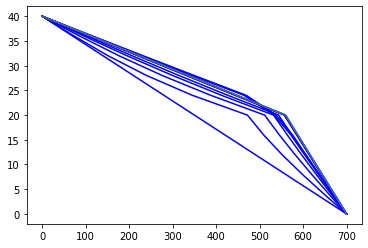

In [17]:
for cont in range(step_initial, step_final + d_step, d_step):  
    
    # Read time
    time = np.loadtxt("time_" + str(cont) + ".txt", dtype="str")
    time = time[:, 2:]
    time = time.astype("float")
    
    temper = pd.read_csv(
        "temperature_" + str(cont) + ".txt",
        delimiter=" ",
        comment="P",
        skiprows=2,
        header=None,
    )
    T = temper.to_numpy()
    T = np.reshape(T,(Nx,Nz),order="F")
    T = np.transpose(T)
   
    print("Step =", cont)
    print("Time = %.1lf Myr\n\n" % (time[0] / 1.0e6))
    
    
    plt.plot(T[::-1,Nx//2],Z[:,Nx//2]/1000,"b")
    
plt.plot(T[::-1,Nx//2],Z[:,Nx//2]/1000,"r")


Tb = 700.0
T1 = 4*Tb/5
plt.plot([0,T1,Tb],[40,20,0])

560.0 0.8


(42.0, -2.0)

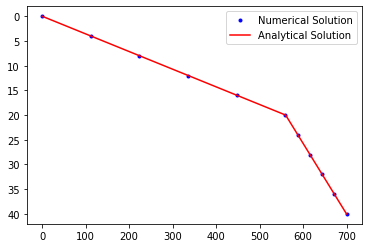

In [21]:
plt.plot(T[:,Nx//2],Z[:,Nx//2]/1000,".b",label="Numerical Solution")
Tb = 700.0
T1 = 4*Tb/5
print(T1,T1/Tb)
plt.plot([0,T1,Tb],[0,20,40],"r", label="Analytical Solution")
plt.legend()
plt.ylim(42,-2)